## CNN Attempt for ISIC 2024 - Skin Cancer Detection with 3D-TBP

Present issue is the massive imbalance in the dataset of positives compared to negatives. To address this issue, I will utilize a custom sampler object called `ImbalancedDatasetSampler` when initiating DataLoader objects.

Another step to increase the effectiveness of CNN on binary classification of skin cancer on the image dataset is using an ensemble of CNN's which is commonly known to increase overall performances.

## Import Libraries

In [3]:
"""
Import libraries
"""
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torcheval.metrics.functional import binary_auroc
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from torch.cuda.amp import autocast, GradScaler

from io import BytesIO
import h5py
import io
import random
import os
from PIL import Image
import cv2
from tqdm import tqdm
import copy
import gc
import time
from collections import defaultdict

# cuda gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Training Configuration

In [4]:
CONFIG = {
    "seed": 42,
    "epochs": 20,
    "img_size": 224,
    "train_batch_size": 150,
    "valid_batch_size": 200,
    "learning_rate": 1e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": device,

    }

In [5]:
"""
Set seed and 
"""


SEED = 111
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

ROOT_DIR = "../data"
TRAIN_CSV = f"{ROOT_DIR}/train-metadata.csv"
TRAIN_HDF = f"{ROOT_DIR}/train-image.hdf5"
TEST_CSV = f'{ROOT_DIR}/test-metadata.csv'
TEST_HDF = f'{ROOT_DIR}/test-image.hdf5'
SAMPLE = f'{ROOT_DIR}/sample_submission.csv'

## Reading in the Data

Code to read in data is from Eren's notebook: https://www.kaggle.com/code/metlnfoor/resnet34-removing-hair-under-sampling/notebook

In [6]:
train_metadata = pd.read_csv(TRAIN_CSV, low_memory=False)
test_metadata = pd.read_csv(TEST_CSV)

In [7]:
# Define oversampling and undersampling strategy
oversample = RandomOverSampler(sampling_strategy=0.003)  
undersample = RandomUnderSampler(sampling_strategy=0.9)  

# Create a pipeline
pipeline = Pipeline([
    ('oversample', oversample),
    ('undersample', undersample)
])

# Fit and transform the data
X_sample, y_sample = pipeline.fit_resample(train_metadata.drop(["target"],axis=1),train_metadata["target"])
X_sample["target"] = y_sample

In [8]:
def read_images_from_hdf5(file_path):
    images = {}
    try:
        with h5py.File(file_path, 'r') as file:
            for key in tqdm(file.keys(), desc="Reading Files"):
                try:
                    image_data = file[key][()]
                    image = Image.open(io.BytesIO(image_data))
                    images[key] = image
                except Exception as e:
                    print(f"Error! from {key}: {e}")
    except Exception as e:
        print(f"Error occured while reading files : {e}")
    
    return images

In [9]:
train_images = read_images_from_hdf5(TRAIN_HDF)
test_images = read_images_from_hdf5(TEST_HDF)

Reading Files: 100%|██████████| 3/3 [00:00<00:00, 1505.31it/s]


## Remove Hair function

In [10]:
def remove_hair(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
    blackhat = cv2.morphologyEx(gray,cv2.MORPH_BLACKHAT,kernel)

    _, thresh = cv2.threshold(blackhat, 10 ,255, cv2.THRESH_BINARY)
    inpainted_image = cv2.inpaint(image, thresh, 1, cv2.INPAINT_TELEA)
    return inpainted_image

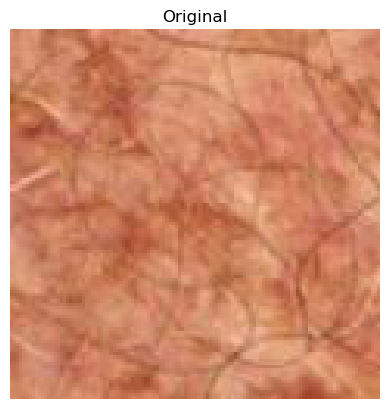

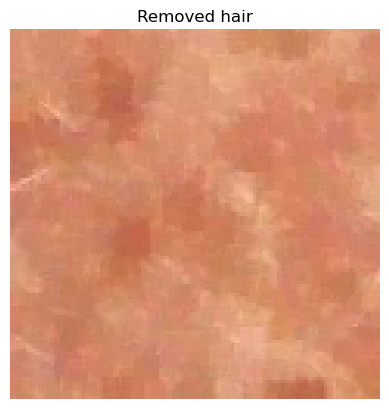

In [11]:
plt.imshow(np.array(test_images["ISIC_0015740"]))
plt.title('Original')
plt.axis('off')
plt.show()

plt.imshow(remove_hair(np.array(test_images["ISIC_0015740"])))
plt.title('Removed hair')
plt.axis('off')
plt.show()


## Dataset Class

Code to make dataset is from Eren's notebook: https://www.kaggle.com/code/metlnfoor/resnet34-removing-hair-under-sampling/notebook

In [12]:
class ISIC_2024(Dataset):
    def __init__(self,pil_images,metadata,transform=None,test=False):
        self.pil_images = pil_images
        self.metadata = metadata
        self.transform = transform
        self.test= test
        
    def __len__(self):
        return len(self.metadata)
    
    # This function from https://www.kaggle.com/competitions/isic-2024-challenge/discussion/519735
    def remove_hair(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
        blackhat = cv2.morphologyEx(gray,cv2.MORPH_BLACKHAT,kernel)

        _, thresh = cv2.threshold(blackhat, 10 ,255, cv2.THRESH_BINARY)
        inpainted_image = cv2.inpaint(image, thresh, 1, cv2.INPAINT_TELEA)
        return inpainted_image
    
    def __getitem__(self,idx):
        isic_id = self.metadata.iloc[idx,0]
        cleaned_image = remove_hair(np.array(self.pil_images[isic_id]))
        image = Image.fromarray(cleaned_image)
        if self.transform:
            image = self.transform(image)
        if self.test:
            return image
        label = self.metadata.iloc[idx,-1]
        return image,label
    # def get_labels(self):
    #     return self.metadata["target"].values

In [13]:
train, val = train_test_split(X_sample,test_size=0.2,stratify=X_sample["target"])

## Get DataLoaders

In [14]:
"""
Define DataLoader Transforms
"""

train_transforms = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5),    
    transforms.RandomRotation(20),           
    transforms.ColorJitter(brightness=0.4, contrast=0.5, saturation=0.2, hue=0.1),
    transforms.ToTensor(),                   
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # commonly used mean and std calculated from ImageNet
])

test_transforms = transforms.Compose([
     transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # commonly used mean and std calculated from ImageNet
])

In [15]:
#init the dataset objects with the transforms
train_dataset = ISIC_2024(train_images, train, transform = train_transforms)
val_dataset = ISIC_2024(train_images, val, transform = test_transforms)
test_dataset = ISIC_2024(test_images, test_metadata, transform = test_transforms, test = True)

In [16]:
# make dataloaders now with ImbalancedDatasetSampler() for training but dont need for val and test loaders
train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, pin_memory=True)

## Define Model 1: ResNet152

In [17]:
class CustomResNet152(nn.Module):
    def __init__(self):
        super(CustomResNet152, self).__init__()
        # Load a pre-trained ResNet-152 model
        self.base_model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
        
        # remove last fully connected layer for our purposes
        self.features = nn.Sequential(*list(self.base_model.children())[:-2])

        # Classifier that includes flattening the feature map and linear layer for class prediction
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(2048, 1),  # output single value for prob calculation
            nn.Sigmoid()  # sigmoid activation for probability
        )
    
    def forward(self, x):
        # extract features
        x = self.features(x)
        # classify features
        output = self.classifier(x)
        return output

In [18]:
model1 = CustomResNet152()
model1 = model1.to(device)

## Define Criterion and Optimizer

In [19]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scaler = GradScaler()  # For mixed precision


## Get Scheduler

In [20]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

scheduler = fetch_scheduler(optimizer)

## Training and Val Loop Function

In [21]:
def eval_or_train(model, dataloader, optimizer, criterion, device, mode = 'eval'):
    if mode == 'train':
        # Init training mode
        model.train()
        # Init running loss, correct preds, and total correct preds for each epoch
        epoch_total_loss = 0.0
        epoch_correct_preds = 0
        epoch_total_preds = 0
        all_labels = []
        all_preds = []

        for data, target in tqdm(dataloader, desc="Training Loop"):

            # Init data and target into cuda
            data = data.to(device)
            target = target.to(device).float()

            optimizer.zero_grad()

            # Mixed precision context
            with autocast():
                # Predict using input data
                curr_pred = model(data)
                
                # Change the shape of target to match prediction
                target = target.view(curr_pred.size())

                # Calculate loss of prediction with true label
                curr_loss = criterion(curr_pred, target)

            # Backprop with scaled loss
            scaler.scale(curr_loss).backward()
            # Gradient descent step with scaler
            scaler.step(optimizer)
            # Update the scaler
            scaler.update()

            epoch_total_loss += curr_loss.item() * data.size(0)
            _, predicted = torch.max(curr_pred, 1)

            epoch_correct_preds += (predicted == target).sum().item()
            epoch_total_preds += target.size(0)

            all_labels.extend(target.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        train_avg_loss = epoch_total_loss / len(dataloader.dataset)
        train_acc = accuracy_score(all_labels, all_preds)

        return train_avg_loss, train_acc
    
    elif mode == 'eval':
        #init eval mode
        model.eval()
        #init running loss, correct preds, and total correct preds for each epoch
        epoch_total_loss = 0.0
        epoch_correct_preds = 0
        epoch_total_preds = 0
        all_labels = []
        all_preds = []

        for data, target in tqdm(dataloader, desc="Eval Loop"):
            
            #init data and target into cuda
            data = data.to(device)
            target = target.to(device).float()

            #predict using input data
            curr_pred = model(data)

            #change the shape of target to match prediction
            target = target.view(curr_pred.size())
            
            #calculate loss of prediction with true label
            curr_loss = criterion(curr_pred, target)

            #add to running loss and get prediction
            epoch_total_loss += curr_loss.item() * data.size(0)
            _, predicted = torch.max(curr_pred, 1)

            #get the number of correct preds and total preds
            epoch_correct_preds += (predicted == target).sum().item()
            epoch_total_preds += target.size(0)

            all_labels.extend(target.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
        
        eval_avg_loss = epoch_total_loss / len(dataloader.dataset)
        eval_acc = accuracy_score(all_labels, all_preds)
        

        return eval_avg_loss, eval_acc
    

## Training Loop

In [22]:
"""
Define EarlyStopping that will be used for training loop
"""

class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

early_stopping = EarlyStopping(tolerance=5, min_delta=0)

In [23]:
torch.cuda.empty_cache()


In [24]:
"""
Run epochs with early stopping - RESNET152
"""
#init loss lists
train_loss_list = []
val_loss_list = []
test_loss_list = []
train_acc_list = []
val_acc_list = []
test_acc_list = []

#for checkpointing later
best_val_loss = 1000000  
output_folder = "./output/"



for e in range(1, 40+1):
    print('Epoch:', e)

    train_loss, train_acc = eval_or_train(model1, train_loader, optimizer, criterion, device, mode = 'train')
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    val_loss, val_acc = eval_or_train(model1, val_loader, optimizer, criterion, device, mode = 'eval')
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    scheduler.step()

    # Checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model1.state_dict(), os.path.join(output_folder, f'res152_ISIC_best.pth'))

    #EARLY STOPPING MECHANISM COMPARING TRAIN AND VAL
    early_stopping(train_loss,val_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", e)
      break
    
    torch.cuda.empty_cache()


    print("Epoch number:", e, "/", 40)
    print("      Train acc -- ", train_acc, "; Train loss -- ", train_loss)
    print("      Validation acc -- ", val_acc, "; Validation loss -- ", val_loss)


Epoch: 1


Eval Loop: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


Epoch number: 1 / 40
      Train acc --  0.5261341222879684 ; Train loss --  0.7046262719457201
      Validation acc --  0.5266272189349113 ; Validation loss --  0.6664951364904701
Epoch: 2


Eval Loop: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


Epoch number: 2 / 40
      Train acc --  0.5261341222879684 ; Train loss --  0.6357026449321995
      Validation acc --  0.5266272189349113 ; Validation loss --  0.6146510944093708
Epoch: 3


Eval Loop: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]


Epoch number: 3 / 40
      Train acc --  0.5261341222879684 ; Train loss --  0.6036074859856149
      Validation acc --  0.5266272189349113 ; Validation loss --  0.6044731261227023
Epoch: 4


Eval Loop: 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]


Epoch number: 4 / 40
      Train acc --  0.5261341222879684 ; Train loss --  0.5932926917687441
      Validation acc --  0.5266272189349113 ; Validation loss --  0.5947798813823647
Epoch: 5


Eval Loop: 100%|██████████| 16/16 [00:04<00:00,  3.21it/s]


Epoch number: 5 / 40
      Train acc --  0.5261341222879684 ; Train loss --  0.5818203879296192
      Validation acc --  0.5266272189349113 ; Validation loss --  0.5869986035179574
Epoch: 6


Eval Loop: 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]


Epoch number: 6 / 40
      Train acc --  0.5261341222879684 ; Train loss --  0.5791733685800075
      Validation acc --  0.5266272189349113 ; Validation loss --  0.5896433471927981
Epoch: 7


Eval Loop: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]


We are at epoch: 7


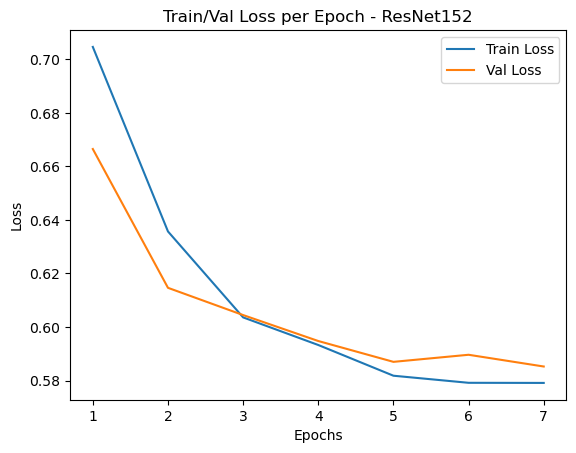

In [25]:
"""
Display losses of ResNet152:
"""

fig = plt.figure()
plt.plot(np.linspace(1, len(train_loss_list), len(train_loss_list)), train_loss_list, label = 'Train Loss')
plt.plot(np.linspace(1, len(train_loss_list), len(train_loss_list)), val_loss_list, label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Loss per Epoch - ResNet152')
plt.legend()
plt.show()

## Try Other Models now